# Kernel Ridge Regression(rbf kernel)

In [2]:
import os
import sys
current_path = os.getcwd()
current_path

'c:\\Users\\Fortyfour\\Desktop\\graduation_design\\Scripts\\Models\\KRR'

In [3]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../../'))

In [4]:
# Importing the custom module
from Utools.draw import model_performance

In [5]:
import pandas as pd
import numpy as np
np.random.seed(42)


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
# save the model 
import joblib

In [6]:
# some global variables
RANDOM_SEED = 42

In [7]:
# Load data
file_dir = r'C:\Users\Fortyfour\Desktop\graduation_design\Scripts\Data\composition_data\feature_data'
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'dft', 'train.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'dft', 'test.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'exp', 'train.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'exp', 'test.csv'))

In [8]:
dft_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41530 entries, 0 to 41529
Columns: 107 entries, composition to band_gap
dtypes: float64(106), object(1)
memory usage: 33.9+ MB


In [9]:
dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp__train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp__train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

In [10]:
def model_train(model, X_train, y_train):
    """
    Train and evaluate a Random Forest Regressor.
    """
    # using pipline to scale the data and fit the model
    pipe = Pipeline([
        ('scaler', StandardScaler()), # StandardScaler's mean is 0 and std is 1, Z-score normalization
        ('model', model)
    ], verbose=True)

    # Fit the model
    pipe.fit(X_train, y_train)
    return pipe

def predict(model, X_test):
    # Predict on the test set
    y_pred = model.predict(X_test)
    return y_pred

In [11]:
# Predict on the test set
def results(model, X_test, y_test, save_df, train_type='dft', test_type='dft'):
    """
    Predict and evaluate the model on the test set.
    Save the results(model, figures, predictions)
    """
    type = f'{train_type}_train_{test_type}_test'
    y_pred = predict(model, X_test)

    # save the results
    # save fig
    fig_path = os.path.join(current_path, 'figures')
    if not os.path.exists(fig_path):
        os.makedirs(fig_path)
    fig_path = os.path.join(fig_path, f'{type}.png')
    r2, rmse, mae = model_performance(y_test, y_pred, fig_path)
    print(f"{type} results:")
    print(f"R^2: {r2:.4f}", f"RMSE: {rmse:.4f}", f"MAE: {mae:.4f}")

    # save the model
    # save the pipeline model(contains scaler and model)
    model_path = os.path.join(current_path, 'model')
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    model_path = os.path.join(model_path, f'{train_type}.pkl')
    joblib.dump(model, model_path)
    # save y_pred
    file_path = os.path.join(current_path, 'predictions')
    if not os.path.exists(file_path):
        os.makedirs(file_path)
    file_path = os.path.join(file_path, f'{type}.csv')
    y_pred_df = save_df.copy()
    y_pred_df['predicted_band_gap'] = y_pred
    y_pred_df.to_csv(file_path, index=False)

    return [r2, rmse, mae]

## Model -- Kernel Ridge Regression

In [12]:
# krr_model = KernelRidge(kernel='rbf', alpha=1.0, gamma=0.1)
# As the memory is not enough, we need to use the kernel approximation
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import Ridge
# create the kernel approximation model
n_components = 8000  # approximation dimension, you can adjust this value
kernel_approx = Pipeline([
    ('nystroem', Nystroem(kernel='rbf',  n_components=n_components, random_state=RANDOM_SEED)),
    ('ridge', Ridge(alpha=1.0))
])

## DFT Train

In [13]:
# dft train
dft_model = model_train(kernel_approx, dft_train_X, dft_train_y)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total= 6.1min


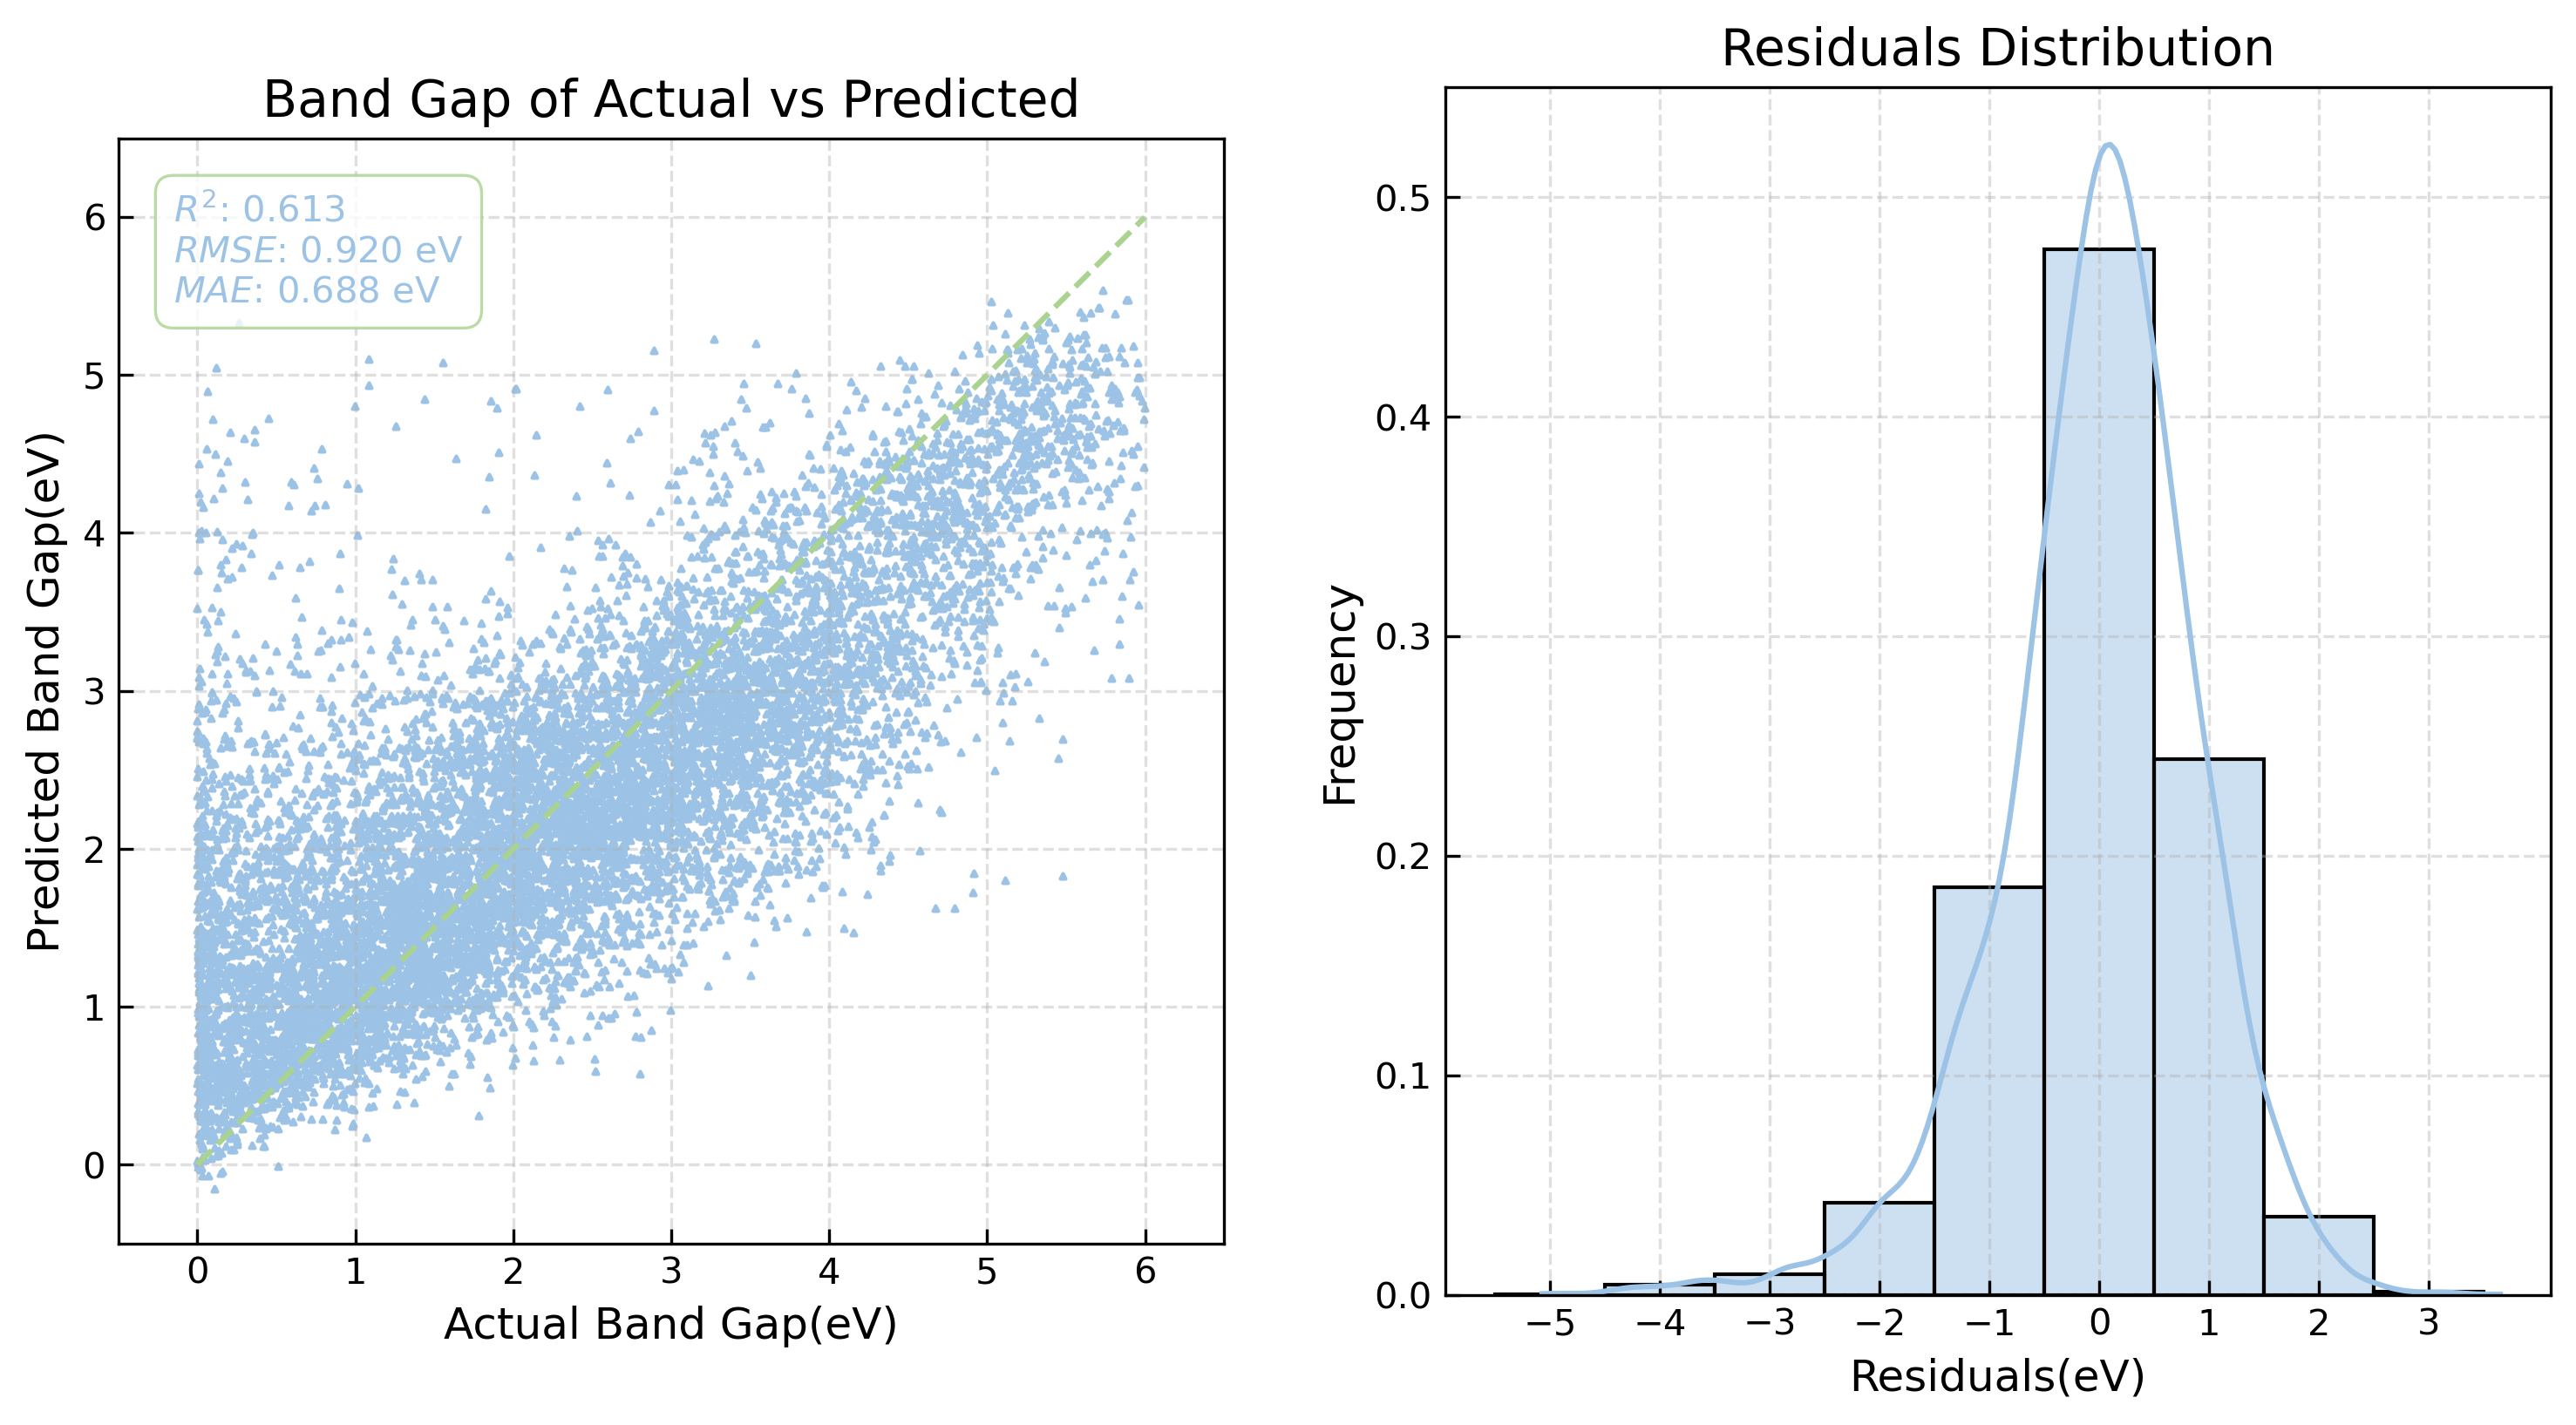

dft_train_dft_test results:
R^2: 0.6127 RMSE: 0.9199 MAE: 0.6877


In [14]:
results_df = pd.DataFrame(columns=['Train', 'Test', 'R^2', 'RMSE', 'MAE'])
# dft test
res1 = results(dft_model, dft_test_X, dft_test_y, dft_test, train_type='dft', test_type='dft')
results_df.loc[len(results_df)] = ['dft', 'dft'] + res1

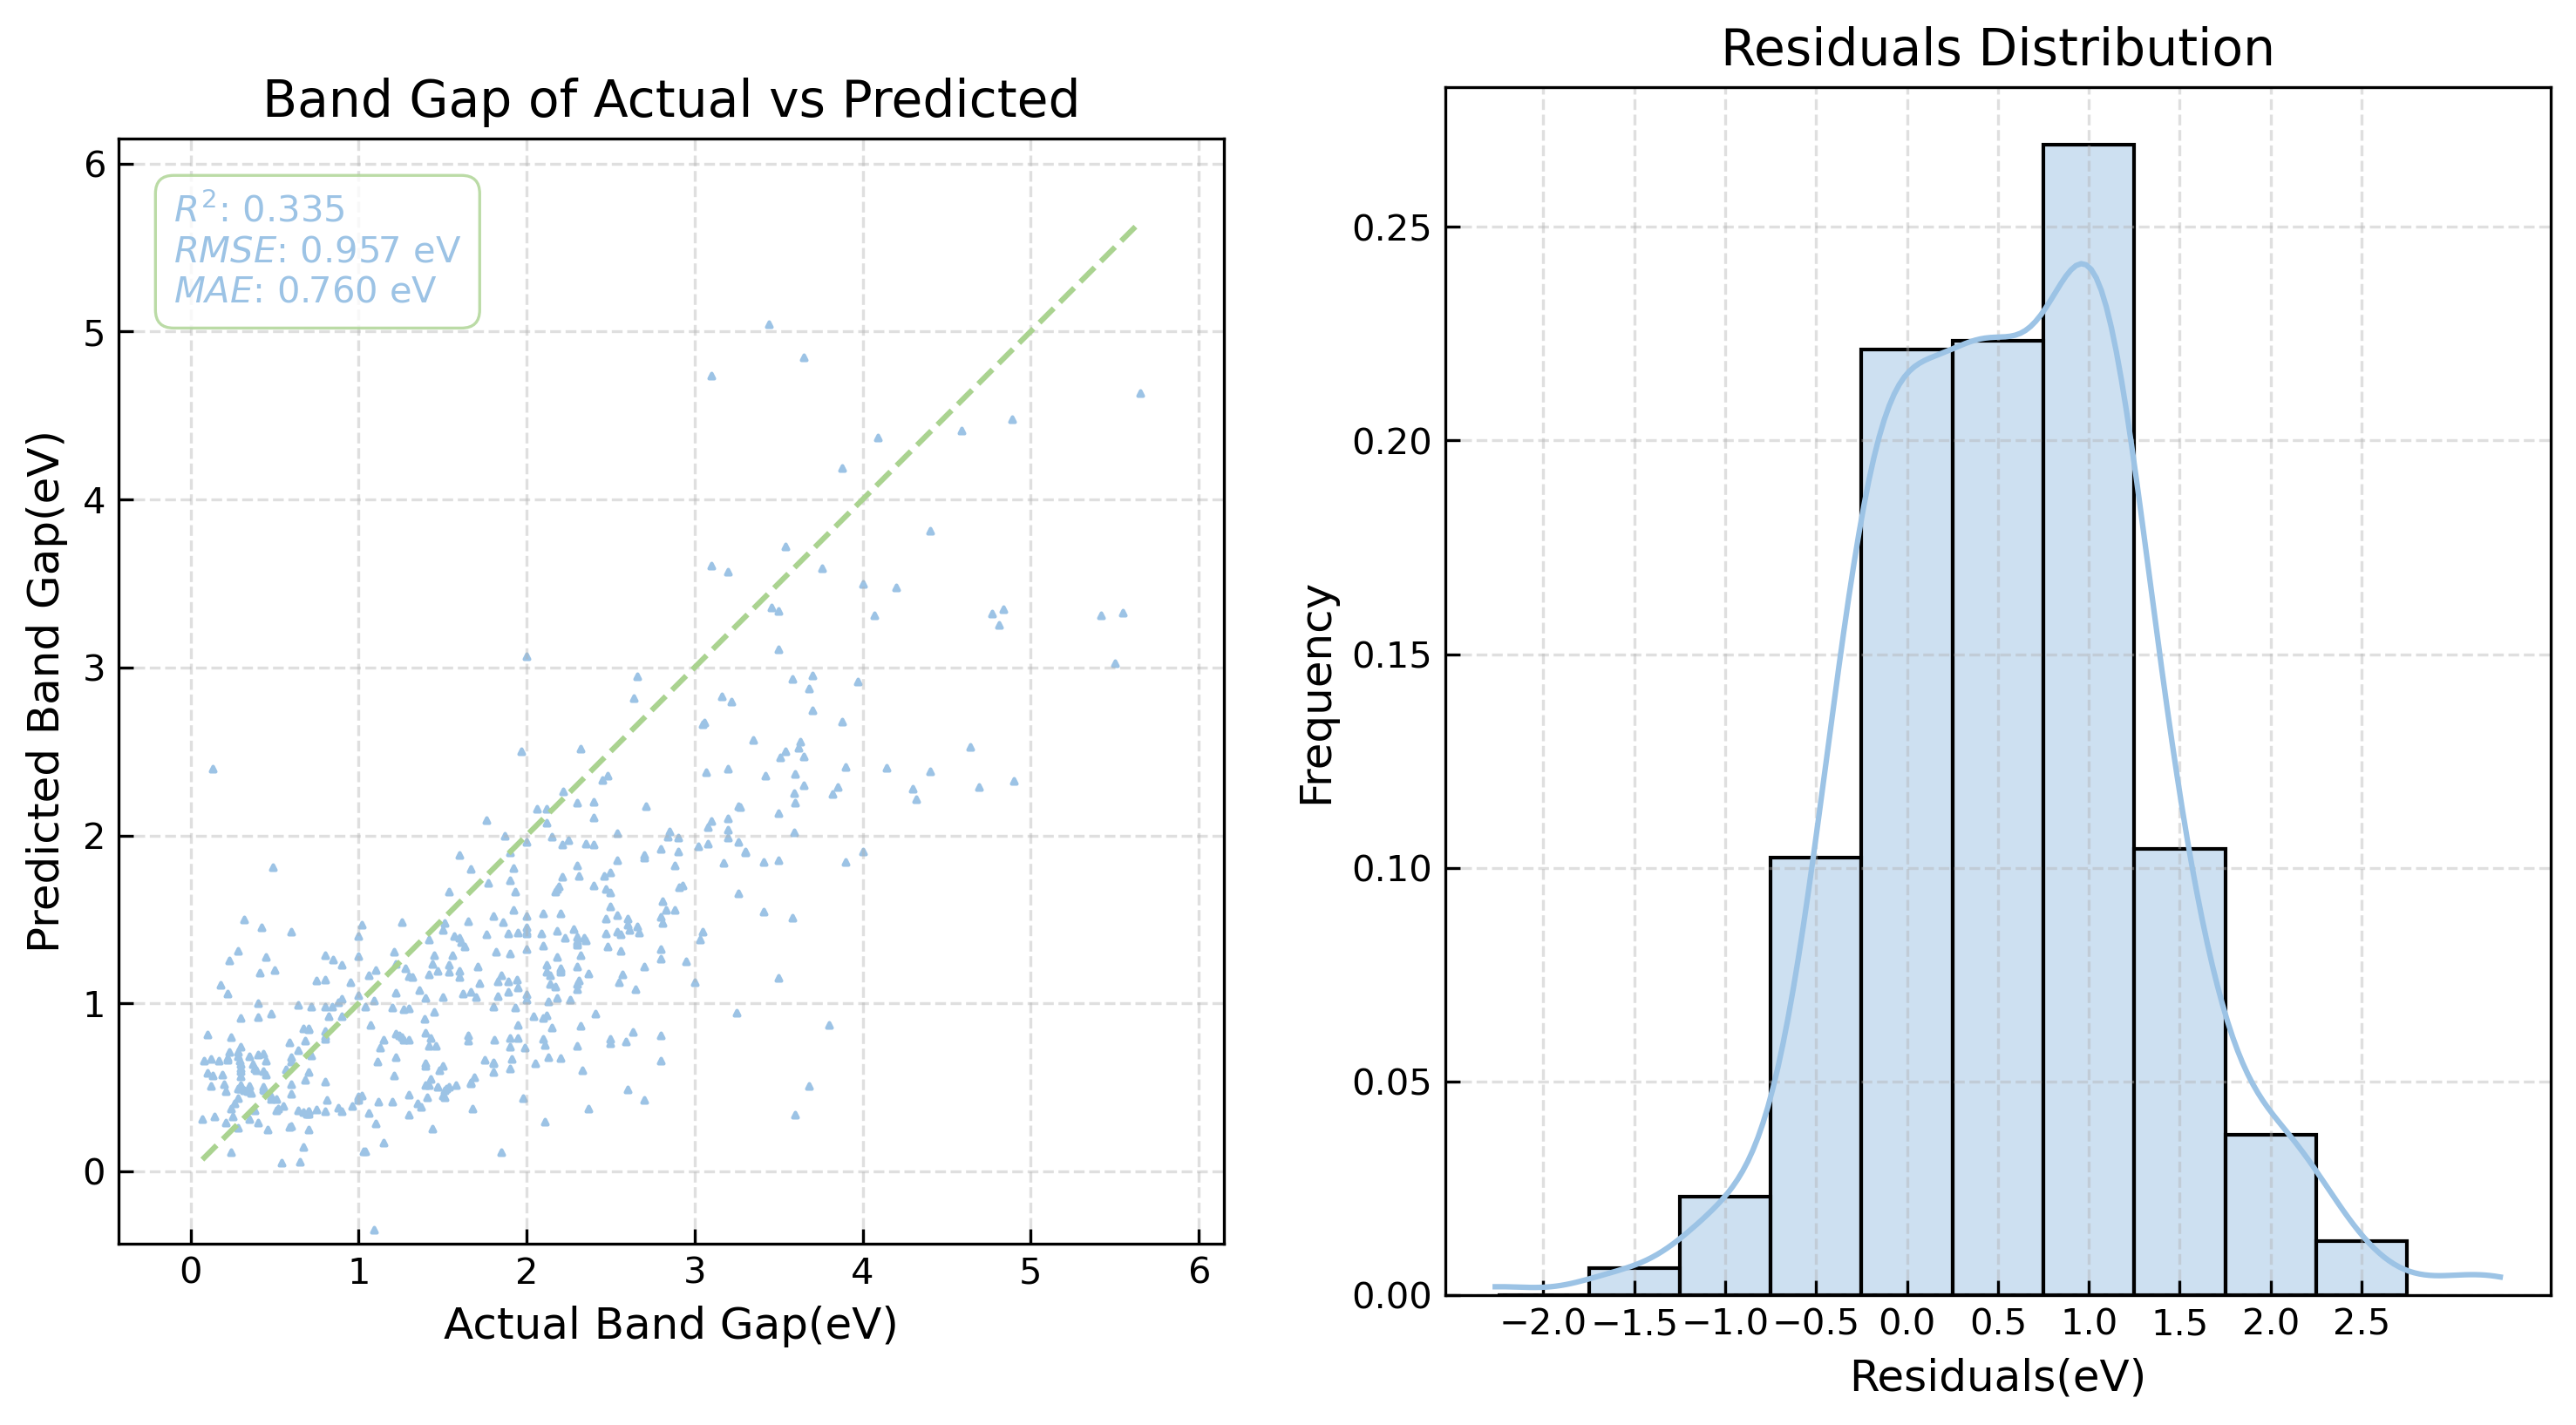

dft_train_exp_test results:
R^2: 0.3345 RMSE: 0.9571 MAE: 0.7598


In [15]:
# Predict on the experimental data
res2 = results(dft_model, exp_test_X, exp_test_y, exp_test, train_type='dft', test_type='exp')
results_df.loc[len(results_df)] = ['dft', 'exp'] + res2

## Experimental train

In [16]:
# the size of experimental data is small, so we have no need to use the kernel approximation
krr_model = KernelRidge(kernel='rbf', alpha=1.0)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.6s


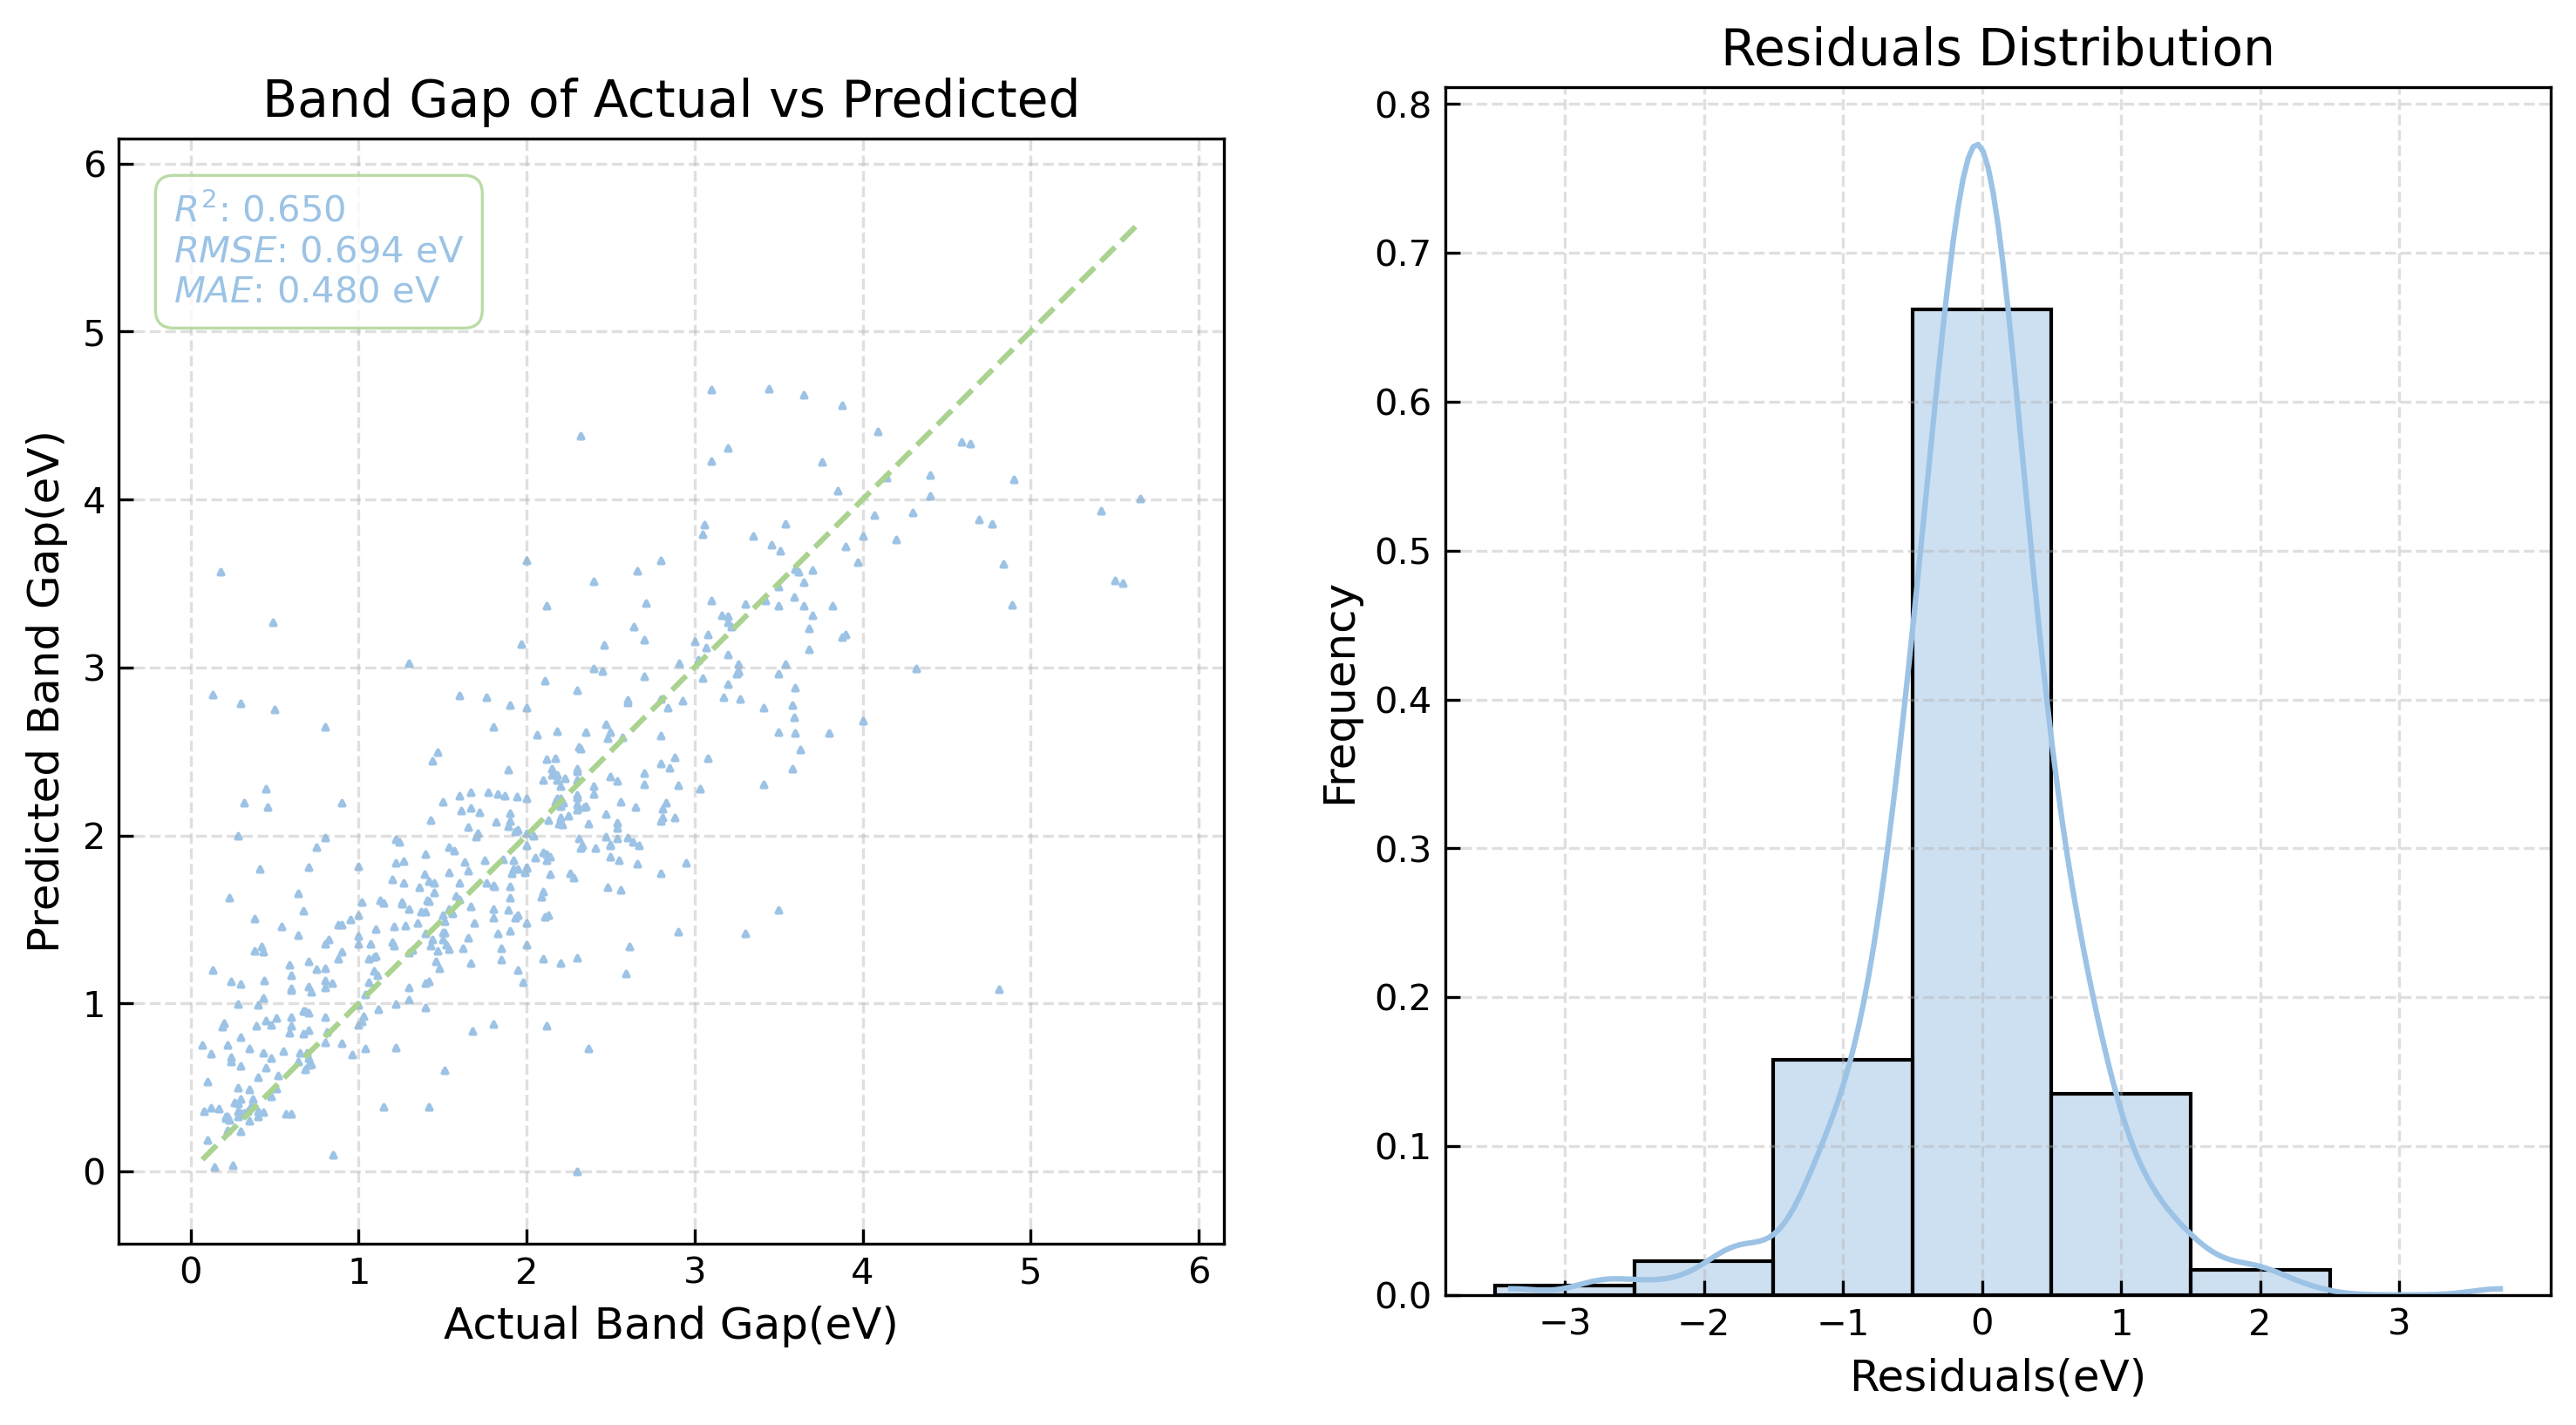

exp_train_exp_test results:
R^2: 0.6496 RMSE: 0.6945 MAE: 0.4796


In [17]:
# Train and evaluate the model on the experimental data
exp_model = model_train(krr_model, exp__train_X, exp__train_y)
# Predict on the test set
res3 = results(exp_model, exp_test_X, exp_test_y, exp_test, train_type='exp', test_type='exp')
results_df.loc[len(results_df)] = ['exp', 'exp'] + res3

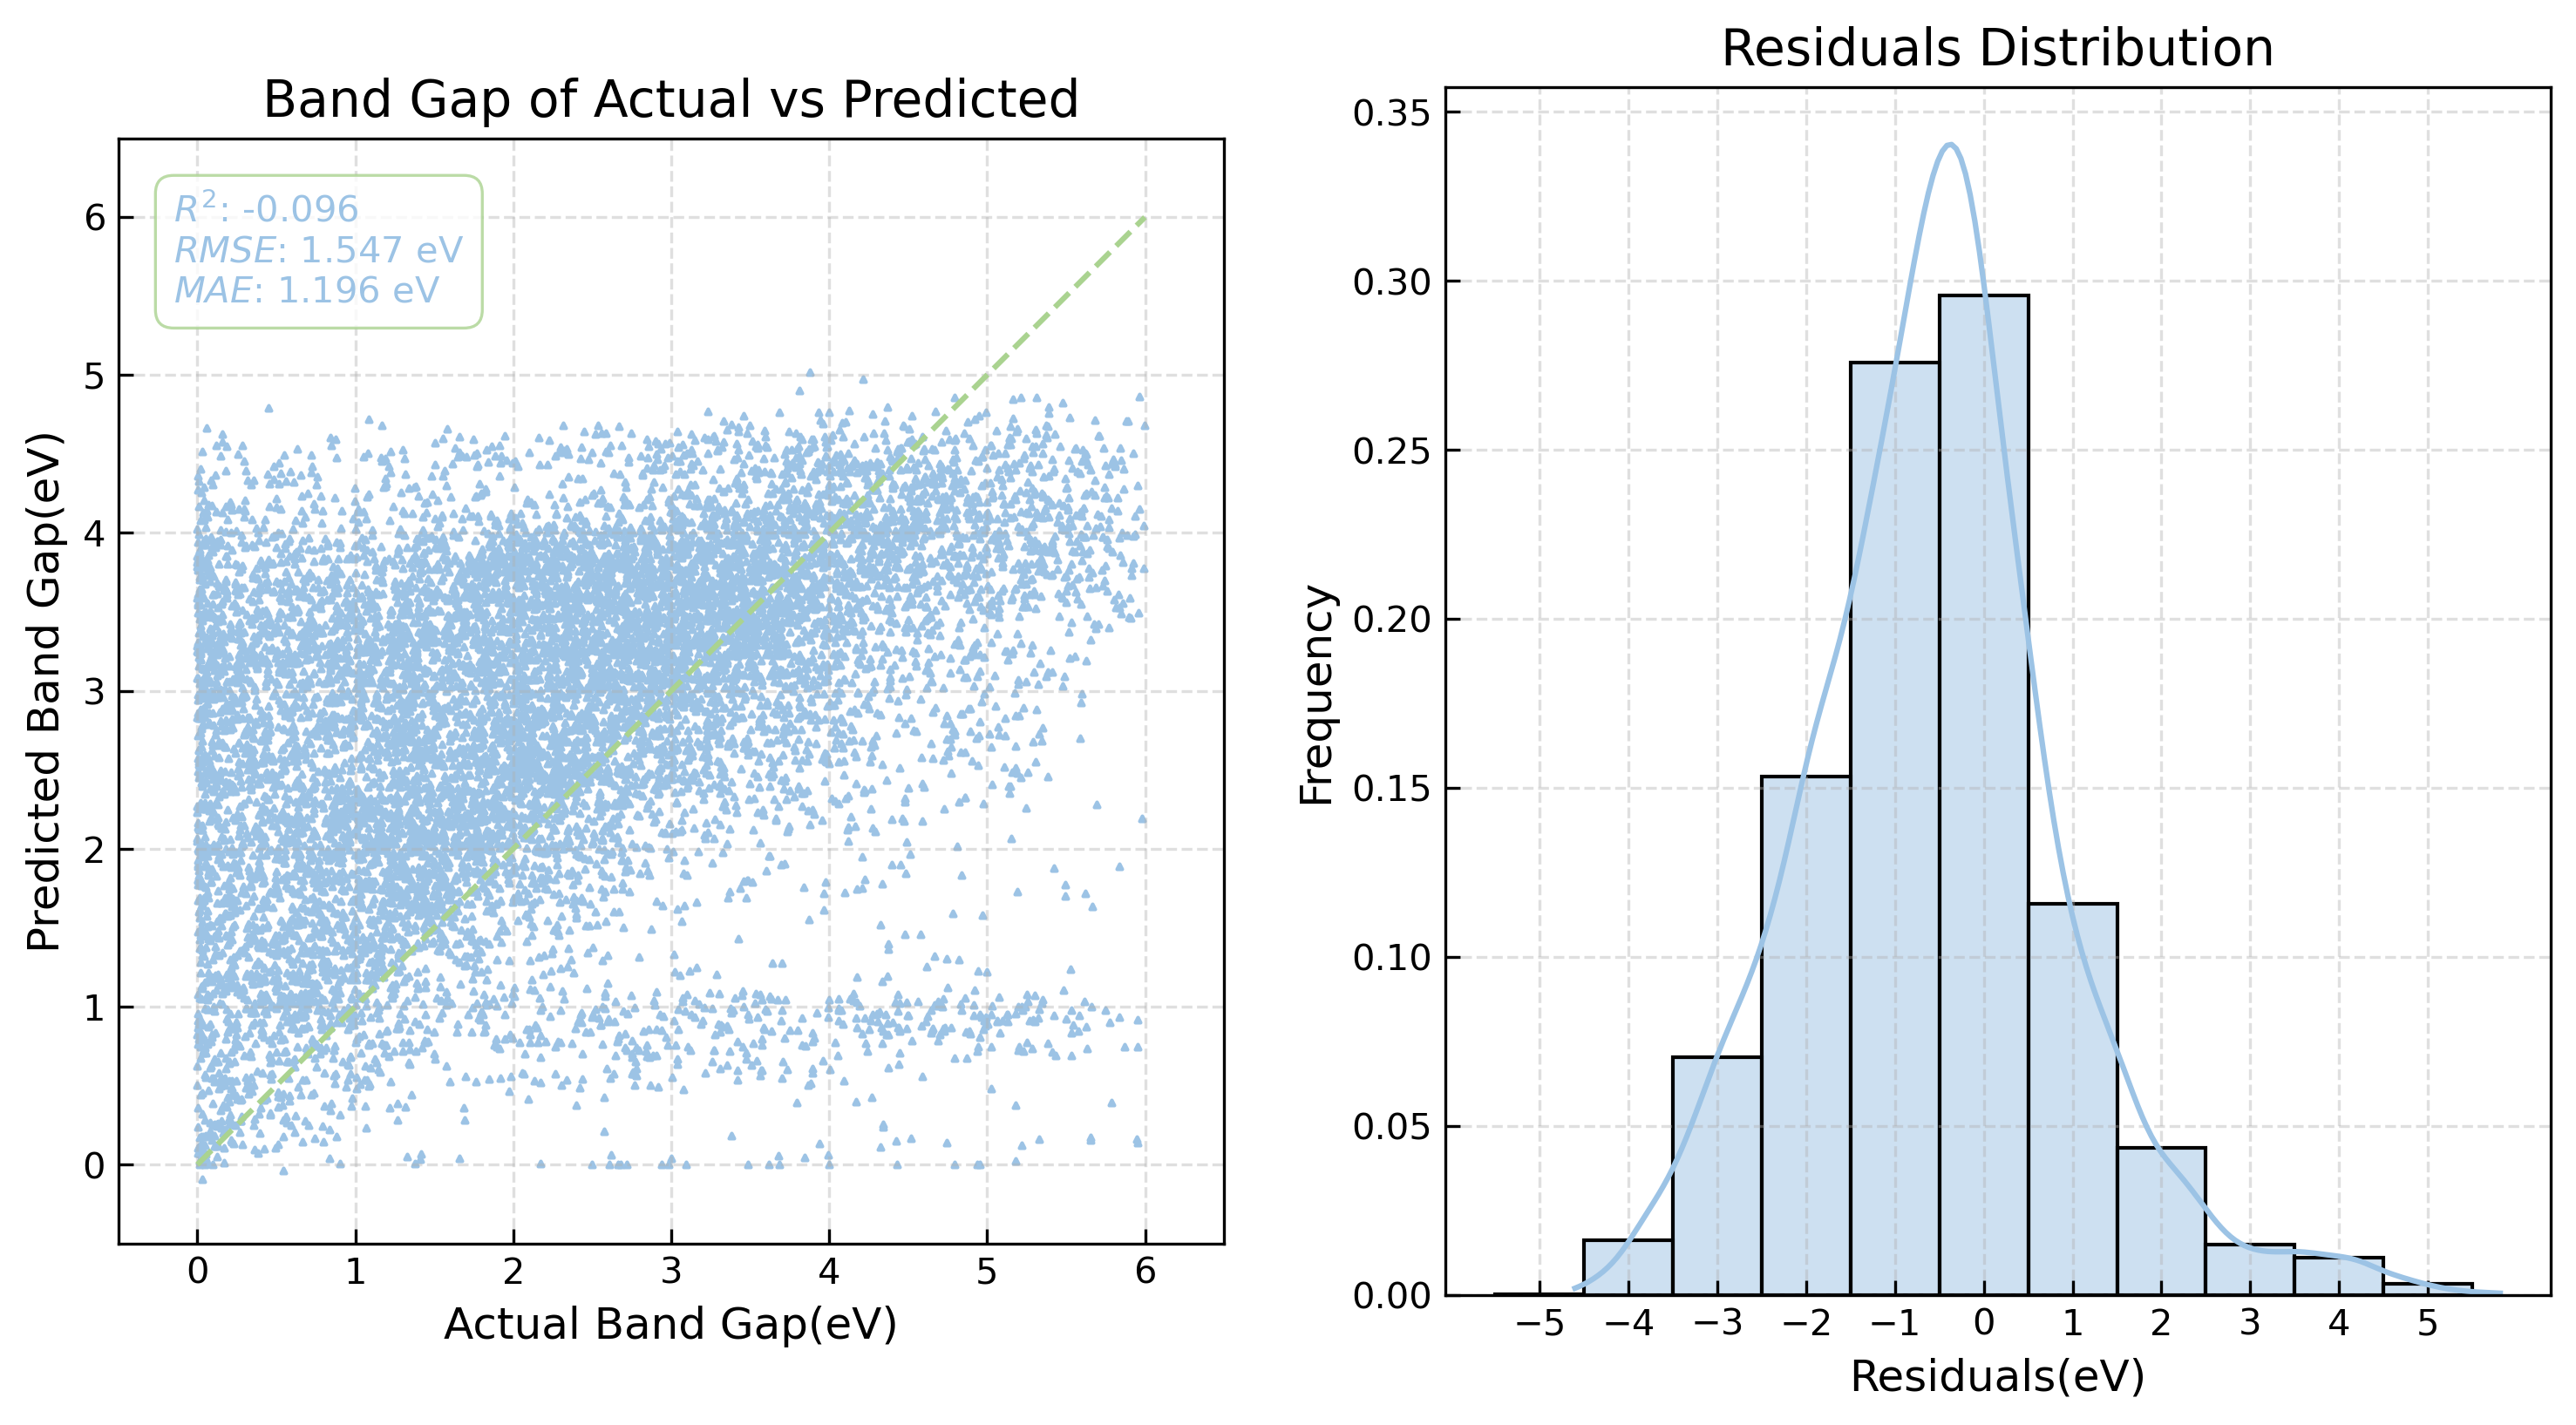

exp_train_dft_test results:
R^2: -0.0955 RMSE: 1.5471 MAE: 1.1964


In [18]:
# Predict on the dft data
res4 = results(exp_model, dft_test_X, dft_test_y, dft_test, train_type='exp', test_type='dft')
results_df.loc[len(results_df)] = ['exp', 'dft'] + res4

In [19]:
results_df

,Train,Test,R^2,RMSE,MAE
0,dft,dft,0.612719,0.919879,0.687716
1,dft,exp,0.334507,0.957068,0.759794
2,exp,exp,0.649620,0.694450,0.479575
3,exp,dft,-0.095500,1.547119,1.196400


In [20]:
# save the results
file_path = os.path.join(current_path, 'model_performance.csv')
results_df.to_csv(file_path, index=False)